In [147]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.metrics import accuracy_score, mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectKBest
import joblib

EMA explanation

In [3]:
def prepare_stock_data(stock):
    df = pd.read_json('../data/historical_data/' + stock + '.json', lines=True)
    df1 = pd.read_json('../data/historical_data/S&P500.json', lines=True)

    # Rename columns
    df = df.rename(columns={'Open': 'Stock Open', 'Close': 'Stock Close'})
    df1 = df1.rename(columns={'Open': 'S&P 500 Open', 'Close': 'S&P 500 Close'})

    # Join dataframes
    df = pd.merge(df[['Date', 'Stock Open', 'Stock Close']], df1[['Date', 'S&P 500 Open', 'S&P 500 Close']],
                  on='Date', how='outer')

    # Add previous day close price
    df['Stock Close Prev'] = df['Stock Close'].shift(1)
    df['S&P 500 Close Prev'] = df['S&P 500 Close'].shift(1)

    # Compute Exponential Mobile Average (EMA) for stock values and index values
    stock_value_ema = df['Stock Close'].copy().ewm(span=10, adjust=False).mean()
    df['Stock Close EMA'] = np.round(stock_value_ema, decimals=3)
    sp500_ema = df['S&P 500 Close'].copy().ewm(span=10, adjust=False).mean()
    df['S&P 500 Close EMA'] = np.round(sp500_ema, decimals=3)

    # Shift EMAs in order to have the previous days trend along with today close value
    df['Stock Close EMA'] = df['Stock Close EMA'].shift(1)
    df['S&P 500 Close EMA'] = df['S&P 500 Close EMA'].shift(1)

    # Add sentiment analysis

    # Drop rows with NaN values
    df.dropna(inplace=True)

    # Re order columns
    df = df[['Date', 'Stock Close', 'Stock Close Prev', 'Stock Close EMA',
             'S&P 500 Close Prev', 'S&P 500 Close EMA']]

    return df

df = prepare_stock_data('AMZN')
df

,Date,Stock Close,Stock Close Prev,Stock Close EMA,S&P 500 Close Prev,S&P 500 Close EMA
1,2017-01-04 00:00:00+00:00,757.18,753.67,753.670,2257.83,2257.830
2,2017-01-05 00:00:00+00:00,780.45,757.18,754.308,2270.75,2260.179
3,2017-01-06 00:00:00+00:00,795.99,780.45,759.061,2269.00,2261.783
4,2017-01-09 00:00:00+00:00,796.92,795.99,765.776,2276.98,2264.546
5,2017-01-10 00:00:00+00:00,795.90,796.92,771.438,2268.90,2265.338
...,...,...,...,...,...,...
1264,2022-01-10 00:00:00+00:00,3229.72,3251.08,3330.825,4677.02,4726.486
1265,2022-01-11 00:00:00+00:00,3307.24,3229.72,3312.442,4670.29,4716.268
1266,2022-01-12 00:00:00+00:00,3304.14,3307.24,3311.496,4713.07,4715.687
1267,2022-01-13 00:00:00+00:00,3224.28,3304.14,3310.159,4726.35,4717.625


In [164]:
x_train, x_test, y_train, y_test = train_test_split(df[['Stock Close Prev', 'Stock Close EMA',
                                                        'S&P 500 Close Prev', 'S&P 500 Close EMA']],
                                                    df[['Stock Close']], test_size=.2,
                                                    shuffle=False, random_state=0)

print('Size of train set: ', x_train.shape)
print('Size of test set: ', x_test.shape)
print('Size of train set: ', y_train.shape)
print('Size of test set: ', y_test.shape)

date_test = df.loc[x_train.shape[0]+1:, ['Date']]

Size of train set:  (1014, 4)
Size of test set:  (254, 4)
Size of train set:  (1014, 1)
Size of test set:  (254, 1)


In [246]:
# Spot-Check Algorithms
regressors = []
regressors.append(LinearRegression())
regressors.append(Lasso())
regressors.append(ElasticNet())
regressors.append(RandomForestRegressor(n_estimators=1000, random_state=30, min_samples_split=2, min_samples_leaf=1, max_depth=6, bootstrap=False))
regressors.append(KNeighborsRegressor(n_neighbors = 5)) 
regressors.append(AdaBoostRegressor())

numeric_transformer = Pipeline(steps=[
    #('select', SelectKBest(k=2)),
    ('scaler', StandardScaler())
    #("pca", PCA())
])

numeric_features = ['Stock Close Prev', 'Stock Close EMA', 'S&P 500 Close Prev', 'S&P 500 Close EMA']

preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, numeric_features)
]) 


In [247]:
for regressor in regressors:  
    
    pipe = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor', regressor)
           ])
    
    # Train the model
    pipe.fit(x_train, y_train.values.ravel())
    
    # Use model to make predictions
    y_pred = pipe.predict(x_test)
    
    # Evaluate the performance
    print("\nTraining ", regressor)
    print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
    print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
    print("Mean Absolute Percentage Error (MAPE):", mean_absolute_percentage_error(y_test, y_pred))
    print("R^2:", r2_score(y_test, y_pred))



Training  LinearRegression()
Mean Absolute Error (MAE): 22.354088614482954
Mean Squared Error (MSE): 991.4031195499792
Mean Absolute Percentage Error (MAPE): 0.02786038236529369
R^2: 0.9660376661609771

Training  Lasso()
Mean Absolute Error (MAE): 20.581219144258775
Mean Squared Error (MSE): 896.0846325634641
Mean Absolute Percentage Error (MAPE): 0.02539241405585725
R^2: 0.9693029759146281

Training  ElasticNet()
Mean Absolute Error (MAE): 78.25585467268876
Mean Squared Error (MSE): 8892.854731520312
Mean Absolute Percentage Error (MAPE): 0.0923355548326191
R^2: 0.6953589360189604

Training  RandomForestRegressor(bootstrap=False, max_depth=6, n_estimators=1000,
                      random_state=30)
Mean Absolute Error (MAE): 100.7361853543332
Mean Squared Error (MSE): 19530.100554246565
Mean Absolute Percentage Error (MAPE): 0.11551310102697766
R^2: 0.33096055292413207

Training  KNeighborsRegressor()
Mean Absolute Error (MAE): 105.1556220472441
Mean Squared Error (MSE): 17737.19118

In [207]:
# Save the Regression Model to disk
filename = 'regression_model.pkl'
final_pipe = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor', regressors[1])
           ])
joblib.dump(final_pipe, filename)

['regression_model.pkl']

Evaluate the model using other test set

In [208]:
def predict_stock_value(stock):
    df = prepare_stock_data(stock)

    # Load the Regression Model
    reg = joblib.load('regression_model.pkl')
    

    # Use model to make predictions
    y_pred = reg.predict(df[['Stock Close Prev', 'Stock Close EMA', 'S&P 500 Close Prev', 'S&P 500 Close EMA']])

    # Evaluate the performance
    print("\nEvaluating " + stock + " Prediction")    
    print("Mean Absolute Error (MAE):", mean_absolute_error(df[['Stock Close']].values, y_pred))
    print("Mean Squared Error (MSE):", mean_squared_error(df[['Stock Close']].values, y_pred))
    print("Mean Absolute Percentage Error (MAPE):", mean_absolute_percentage_error(df[['Stock Close']].values, y_pred))
    print("R^2:", r2_score(df[['Stock Close']].values, y_pred))
    
    # Plot predictions and real values
    date_test = df.loc[:df.shape[0] + 1, ['Date']]
    plt.xticks(rotation=45)
    plt.plot_date(date_test, df[['Stock Close']].values, fmt='b-', xdate=True, ydate=False, label='Real value')
    plt.plot_date(date_test, y_pred, fmt='r-', xdate=True, ydate=False, label='Predicted value')
    plt.legend(loc='upper center')
    plt.ylabel('Close prices')
    plt.title('NASDAQ:' + stock)


Evaluating TSLA Prediction
Mean Absolute Error (MAE): 7.271142805630847
Mean Squared Error (MSE): 243.03149906948653
Mean Absolute Percentage Error (MAPE): 0.026759692854211307
R^2: 0.997409744024849


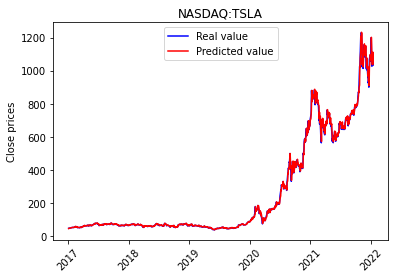

In [209]:
predict_stock_value('TSLA')


Evaluating AAPL Prediction
Mean Absolute Error (MAE): 1.1232575767995812
Mean Squared Error (MSE): 2.978416453083985
Mean Absolute Percentage Error (MAPE): 0.014731548136186762
R^2: 0.9982660135293483


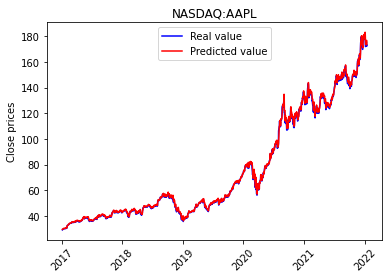

In [210]:
predict_stock_value('AAPL')


Evaluating GOOGL Prediction
Mean Absolute Error (MAE): 17.784971054046913
Mean Squared Error (MSE): 712.1953324172825
Mean Absolute Percentage Error (MAPE): 0.01237087841258003
R^2: 0.9979597035139441


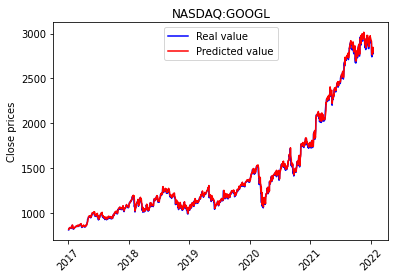

In [211]:
predict_stock_value('GOOGL')


Evaluating MSFT Prediction
Mean Absolute Error (MAE): 2.0077311830153706
Mean Squared Error (MSE): 9.702127430965824
Mean Absolute Percentage Error (MAPE): 0.012720776457677505
R^2: 0.9983549318097311


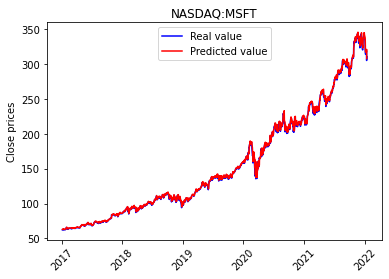

In [212]:
predict_stock_value('MSFT')


Evaluating GOOGL Prediction
Mean Absolute Error (MAE): 17.784971054046913
Mean Squared Error (MSE): 712.1953324172825
Mean Absolute Percentage Error (MAPE): 0.01237087841258003
R^2: 0.9979597035139441


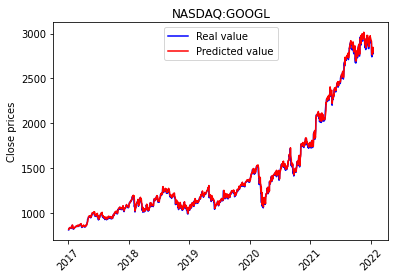

In [213]:
predict_stock_value('GOOGL')